# Lecture 8) Neuro - get started mit Keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms

#import theano 
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import InputLayer,Dense, Activation
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils.np_utils import to_categorical  
from keras.utils.vis_utils import plot_model


Neuronale Netze können sowohl für die Regression als auch für die Klassifikation eingesetzt werden.

Dabei ist allerdings bei der Konfiguration auf ein paar Dinge zu achten (später dazu mehr).

Um ein konfiguriertes Netz mit Trainingsdaten lernen zu lassen haben wir verschiedene Verfahren kennengelernt.
Der Gradientenabstieg (mit oder ohne Batches) ist das klassische Verfahren.

Wenn ein Netz trainiert wird ist es sehr hilfreich währenddessen den Fehler beobachten zu können.
Dazu ist hier eine eigene Funktion definiert (PlotLosses), die das ganz einfach ermöglicht.

In [2]:
# updatable plot

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

Als Tool um Neuronale Netze zu realisieren wird hier Keras verwendet.
SKlearn hat auch eine solche Modellklasse ist allerdings nicht so flexibel wie Keras.

Keras kann als Backend auf Tensorflow, Theano oder CNTK aufbauen.
Die gesamte Doku zu Keras finden Sie unter:
https://keras.io

Tensorflow bringt mittlerweile seine eigene Keras-Implementierung mit

tf.keras

Dabei wird als backend nur tensorflow unterstützt (Nachteil). Der Vorteil dabei
sind ein paar Zusatzfeatures. Wir benutzen hier also tf.keras...

### 8.1) Neuro für Regression mit der keras Sequential API

Je nachdem, ob wir eine Klassifikation oder eine Regression durchführen wollen müssen wir unser Neuro anders konfigurieren.
In jedem Fall muß aber darauf geachtet werden, daß der Wertebereich der Input-Features zu den verwendeten Aktivierungsfunktionen im Netz paßt.
Es gilt:

- tanh, sigmoid -> Werte zwischen -1 und 1
- reLU -> Werte zwischen 0 und 1 (negative würden sonst abgeschnitten!)

Für die erste Regressionsaufgabe wird der Auto-Datensatz verwendet und die Daten werden mit
Hilfe des sklearn StandardScaler auf den Bereich von -1 und 1 transformiert (ca. 64% der Daten liegen dann exakt im Intervall)

In [3]:
Auto = pd.read_csv("../Daten/Auto.csv")
Auto.head()

X=np.array(Auto[['cylinders','displacement','horsepower','weight','acceleration','year']])
y=np.array(Auto['mpg'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle='True')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
print(X_train.shape)

(277, 6)


Ein Keras Sequential Model ist die einfachste Form eines Keras Modelles.  
Es besteht aus einem stack von beliebig vielen Schichten, die sequentiell verbunden sind.
Die Schichten werden mit 'add' aneinandergehängt.

Eine Liste von verfügbaren Schichten und deren Beschreibung finden Sie unter:  

https://keras.io/api/layers/

Für das erste super-einfache Netz brauchen wir erstmal

- Input Layer

tf.keras.layers.InputLayer(
    input_shape=None,
    batch_size=None,
    dtype=None,
    input_tensor=None,
    sparse=None,
    name=None,
    ragged=None,
    type_spec=None,
    **kwargs
)
- Hidden layer=Dense

tf.keras.layers.Dense(
    units,
    activation=None,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

- Output Layer = Dense

Anzahl der Neuronen = Dimension der Zielgröße

Weil wir ein Regressionsproblem bearbeiten braucht die letzte Schicht (Output) keine Aktivierungsfunktion.
Gibt man bei der letzten Schicht nichts an, dann gilt der Default: Aktivierung = Id (Id(x)=x).  
activation = 'linear' ist dazu äquivalent.


In [5]:
NNRegModel=Sequential()

NNRegModel.add(InputLayer(input_shape=(6,)))
NNRegModel.add(Dense(10,activation='tanh',use_bias=True))
NNRegModel.add(Dense(1,use_bias=True))


Das summary des Modelles ist nützlich für den Überblick.
Die Anzahl der Parameter im Modell hängt von der Anzahl der Neuronen in der Dense-Layer und 
Dim(Input), Dim(Target) ab.

Falls use_bias=True dann ist es jeweils eines mehr...

In [6]:
NNRegModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


Die Schichten im Netz haben Namen und können damit auch angesprochen werden

In [7]:
hidden1=NNRegModel.layers[0]
hidden1.name

'dense'

Alle Parameter einer Schicht können über
get_weights() und set_weights() angesprochen werden.  
Beispiel:

In [8]:
weights, biases = hidden1.get_weights()
print('weights',weights)
print('biases',biases)

weights [[ 0.19777119  0.46213537  0.46191424 -0.03572482  0.3169592   0.46739453
   0.27001417  0.50041395  0.01713377 -0.56679857]
 [-0.37774846  0.47016865  0.50414497 -0.2178098   0.25602806  0.22395045
   0.379327   -0.31842986 -0.58198893 -0.18738028]
 [-0.502653   -0.2558581   0.60771745 -0.15531349 -0.46491468 -0.56490976
  -0.48791555 -0.01815945 -0.3077375   0.52313536]
 [ 0.00337702  0.3576818  -0.5889203   0.08634937  0.120175    0.01696432
  -0.00076312 -0.61199635 -0.51147264  0.1600092 ]
 [ 0.36465657  0.11195135 -0.32355246  0.26153988  0.23745936 -0.27887046
   0.3389436   0.24853832  0.22364837 -0.11808223]
 [-0.5964743  -0.3100126   0.2529214  -0.34630293 -0.05203927 -0.2567538
   0.11133379 -0.46294135 -0.0698939  -0.19033942]]
biases [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Frage: Was sehen wir jetzt gerade im Moment?

Jetzt muß das Modell noch kompiliert werden. Dazu verwendet man die Methode compile().  
Dabei wird festgelegt, welche Fehlerfunktion (Loss) verwendet werden soll und welches Lernverfahren angewandt wird.

Danach folgt das eigentliche Training.
Bei model.fit()
werden alle Dinge festgelegt, die das Training betreffen:

- sollen die Daten durchgemischt werden
- Anzahl Lernepochen
- Batch Size (=1 => Pattern by Pattern, =n => Steepest Descent)
- Ausgabe des Loss während des Trainings
- soll der Trainingsprozeß überwacht werden (callbacks)
- einen solchen Callback haben wir mit unserer PlotLosses Funktion!

### Achtung: ruft man das Training mehrmals auf ohne das Modell wieder neu zu initialisieren wird einfach munter auf den schon trainierten Gewichten weitergelernt! :-) 

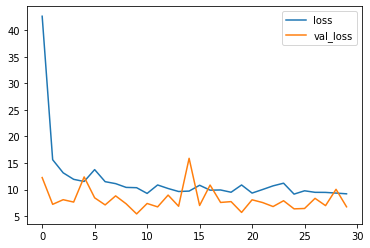

In [9]:
NNRegModel=Sequential()

NNRegModel.add(InputLayer(input_shape=(6,)))
NNRegModel.add(Dense(10,activation='tanh',use_bias=True))
NNRegModel.add(Dense(1,use_bias=True))

sgd = SGD(lr=0.3)
NNRegModel.compile(loss='mean_squared_error', optimizer='sgd')

NNRegModel.fit(X_train, y_train,
          shuffle=True,
          epochs=30, #300,
          batch_size=1,
          verbose=0,
          validation_data=(X_test, y_test),                  
          callbacks=[plot_losses])

In [10]:
y_hat_tr_NN=NNRegModel.predict(X_train)
y_hat_test_NN=NNRegModel.predict(X_test)

In [11]:
rmse_NN_tr = sqrt(mean_squared_error(y_hat_tr_NN,y_train)) 
rmse_NN_test = sqrt(mean_squared_error(y_hat_test_NN,y_test)) 

print('Trainingsfehler:',rmse_NN_tr)
print('Testfehler:',rmse_NN_test)

Trainingsfehler: 2.9292032812431965
Testfehler: 2.5968709648773216


Auch bei Neuronalen Netzen kann es zum Overfitting kommen!
Mit Hilfe des Early Stopping kann man zu dem Zeitpunkt das Training stoppen, zu dem der Testfehler sein Minimum erreicht.

Keras hat dafür einen "callback"

EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Die patience sagt dabei aus wieviele Epochen nach einem guten Wert der Testfehler steigen muß, damit das Training beendet wird.

Ist die Option

restore_best_weights=True

dann wird das beste Modell (innerhalb der geprüften Patience) am Ende aufgerufen (=False => letzter Wert)

Der callback wird im .fit mit aufgerufen

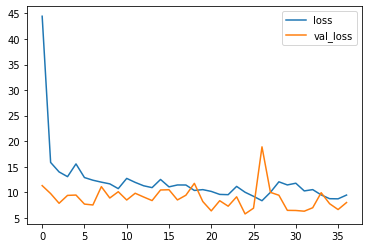

In [12]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,restore_best_weights=True)

NNRegModel1=Sequential()

NNRegModel1.add(InputLayer(input_shape=(6,)))
NNRegModel1.add(Dense(10,activation='tanh',use_bias=True))
NNRegModel1.add(Dense(1,use_bias=True))

sgd = SGD(lr=0.3)
NNRegModel1.compile(loss='mean_squared_error', optimizer='sgd')

NNRegMod1History=NNRegModel1.fit(X_train, y_train,
          shuffle=True,
          epochs=70,
          batch_size=1,
          verbose=0,
          validation_data=(X_test, y_test),                  
          callbacks=[plot_losses, EarlyStopping])

In [13]:
len(NNRegMod1History.history['loss'])  # Das Modell trainiert 38 Epochen

37

In [14]:
y_hat_tr_NN1=NNRegModel1.predict(X_train)
y_hat_test_NN1=NNRegModel1.predict(X_test)

rmse_NN_tr1 = sqrt(mean_squared_error(y_hat_tr_NN1,y_train)) 
rmse_NN_test1 = sqrt(mean_squared_error(y_hat_test_NN1,y_test)) 

print('Trainingsfehler:',rmse_NN_tr1)
print('Testfehler:',rmse_NN_test1)

Trainingsfehler: 3.938000041086017
Testfehler: 4.3454852516927955


### Aufgabe 1)

Die patience hat natürlich einen entscheidenden Einfluß auf das early Stopping!

- Testen Sie den Einfluß der Patience in einer Schleife.
- Für welche Patience wird das beste Endergebnis erzielt?
- Verringern Sie die Lernrate auf 0.1. Wie sieht es jetzt aus?


### 8.2) Neuro für Klassifikation

Um mit einem 3-Layer FFNN eine Klassifikationsaufgabe zu lösen muß die Struktur des Netzes angepaßt werden.

Beim Input ist alles beim Alten. Auch die Aktivierungsfunktion der Hidden-Schicht ist mehr oder weniger frei wählbar.  
Beim Output gibt es Änderungen:

- die Dimension der Output-Layer hängt jetzt von der Anzahl der Klassen ab (1-Hot-Kodierung!): #Klassen = #Neuronen
- die Aktivierungsfunktion auf der Output-Schicht muß dafür sorgen, daß tatsächlich Wahrscheinlichkeiten für die Zugehörigkeit eines Samples herauskommen.  
Das erledigt die activation='softmax'

Auch die Fehlerfunktion für das Training muß angepaßt werden:  

- binäre Klassifikation => loss='binary_crossentropy'  
- mehrere klassen => loss='categorical_crossentropy'

In [15]:
Heart = pd.read_csv("../Daten/heart.csv")
#len(Heart)
#Heart.head()

Heart_y=Heart['AHD']
Heart_X=np.array(Heart[['Age','Sex','RestBP','Chol','Fbs','RestECG','MaxHR','ExAng','Oldpeak','Slope']])


Heart_y=np.array(Heart_y.replace(['No', 'Yes'], [0,1]))
#Heart_y



X_train_H, X_test_H, y_train_H, y_test_H = train_test_split(Heart_X, Heart_y, test_size=0.3, shuffle='True')

scaler = StandardScaler()
X_train_H = scaler.fit_transform(X_train_H)
X_test_H = scaler.transform(X_test_H)

In [16]:
print('mean:',np.mean(X_train_H[:,0]))
print('std:',np.std(X_train_H[:,0]))

mean: -2.1781518387884023e-16
std: 1.0


In [17]:
y_train_H

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0])

Aus der Zielgröße müssen wir noch eine 1-Hot enkodierte Größe machen.  
Bei zwei Klassen ginge es auch anders, aber konsistenter ist es auf diese Art.
Dazu kann man Keras benutzen:


In [18]:
from keras.utils.np_utils import to_categorical  


y_train_H_bin = to_categorical(y_train_H,num_classes = 2)
y_test_H_bin = to_categorical(y_test_H,num_classes = 2)
#print(y_train_bin);

In [19]:
print(X_train_H.shape)
print(y_train_H_bin.shape)

(210, 10)
(210, 2)


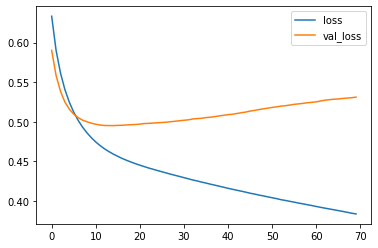

In [20]:
#EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,restore_best_weights=True)

NNClassModel=Sequential()

NNClassModel.add(InputLayer(input_shape=(10,)))
NNClassModel.add(Dense(10,activation='tanh',use_bias=True))
NNClassModel.add(Dense(2,activation='softmax',use_bias=True))

sgd = SGD(lr=0.005)
NNClassModel.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

NNClassModHistory=NNClassModel.fit(X_train_H, y_train_H_bin,
          shuffle=True,
          epochs=70,
          batch_size=1,
          verbose=0,
          validation_data=(X_test_H, y_test_H_bin),                  
          callbacks=[plot_losses])

Die PlotLosses Funktion liefert uns eine graphische Dartsellung der Loss-Funktion.
Das ist in diesem Fall die 'binary_crossentropy'.
Natürlich gilt auch hier: kleiner Loss => besserer Fit
    
Aber richtig interpretieren (in Bezug auf die accuracy) ist nicht ganz so einfach.
Man kann die accuracy während des Trainings nachher auch zeichnen lassen mit Hilfe der History.

In [21]:
#NNClassModHistory.history['accuracy']

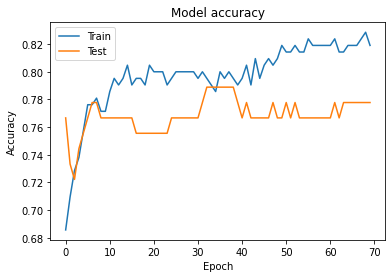

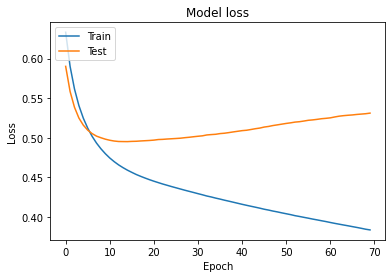

In [22]:
# Plotte Training & Validation accuracy (Hit Rate)
plt.plot(NNClassModHistory.history['accuracy'])
plt.plot(NNClassModHistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotte Training & Validation loss (hängt von der Loss-Funktion beim Training ab)
plt.plot(NNClassModHistory.history['loss'])
plt.plot(NNClassModHistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Das Modell neigt offenbar stark zum Overfitting!
Dagegen sollte man etwas tun...

### Aufgabe 2)

- Untersuchen Sie zuerst für die gegebene Batch Size von 1, welchen Einfluß die Lernrate hat.
- Fixieren Sie jetzt die Lernrate bei 0.01 und variieren Sie die Batch Size. Welchen Effekt kann man beobachten?
- Wählen Sie eine "gute" Kombi von Lernrate und Batch Size und implementieren Sie ein Early Stopping.
- Werten Sie das Modell aus und vergleichen Sie es mit den früheren Klassifikatoren.
- Läßt sich eine Verbesserung erzielen, wenn man mehr (weniger) Neuronen in der Hidden-Schicht benutzt?
- Bringt eine weitere Dense Layer noch eine Verbesserung?